## Introduction
To improve the quality of the trained DSR Model, we investigate the possibility of having a customised VQ-VAE module *(Vector Quantized Variational Autoencoder)*. \
This approach aims to enhance the model's ability to learn discrete latent representations while preserving the continuity of the embedding space. \
By implementing a tailored VQ-VAE architecture, we can better capture the underlying patterns in the data and improve the overall performance and interpretability of the DSR Model, thus allowing for more efficient feature extraction and potentially better generalization to unseen data.

## Reconstruction Quality Comparison
Compare VQ-VAE model trained on semiconductor images against the default *ImageNet Pretrained VQ-VAE Model*. \
Using an unseen dataset, compare the reconstruction error of both models against the following metrics :
- **L1/L2 (MSE) Reconstruction Error**
- **SSIM (Structure Similarity)**

Load Dataset as well as the 2 VQ-VAE Models.

In [15]:
# IMPORTS
import torch
import torch.nn.functional as F
from pathlib import Path
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from anomalib.models.image.dsr.torch_model import DiscreteLatentModel, DsrModel
from anomalib.models.image import Dsr

# Your pretrained wafer VQ-VAE checkpoint
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

WAFER_VQVAE_CKPT = Path("../weights_vqvae_pretrain/vqvae-wafer-epoch=079-val_recon_l1=0.0000.ckpt")

# Dataset
DATA_ROOT = Path("../data/configA")
TEST_ROOT = DATA_ROOT / "test"    # contains normal/ and anomalous/

IMAGE_SIZE = 512
BATCH_SIZE = 4

DEVICE, TEST_ROOT.exists()

# ---------------- DATA MODULE ----------------
tfm = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # NO ImageNet normalization
])

test_dataset = ImageFolder(root=str(TEST_ROOT), transform=tfm)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Classes:", test_dataset.classes)
print("Total test images:", len(test_dataset))

# ---------------- HELPER FUNCTIONS ----------------
def pick_reconstruction(out, x):
    """
    Given the output of a VQ-VAE model, pick the reconstruction tensor.
    The output can be either a tensor or a dict of tensors.
    """
    if isinstance(out, dict):
        for k, v in out.items():
            if torch.is_tensor(v) and v.shape == x.shape:
                return v, k
        raise RuntimeError(f"No reconstruction tensor found. Keys = {list(out.keys())}")
    elif torch.is_tensor(out):
        return out, "<tensor>"
    else:
        raise RuntimeError(f"Unexpected output type {type(out)}")

def get_attr_chain(obj, chain: str):
    """Safely resolve nested attrs like 'model.discrete_model'. Returns None if missing."""
    cur = obj
    for part in chain.split("."):
        if not hasattr(cur, part):
            return None
        cur = getattr(cur, part)
    return cur


# ---------------- LOAD MODELS ----------------

def load_wafer_vqvae(ckpt_path):
    model = DiscreteLatentModel(
        num_hiddens=128,
        num_residual_layers=2,
        num_residual_hiddens=64,
        num_embeddings=4096,
        embedding_dim=128,
    ).to(DEVICE).eval()

    ckpt = torch.load(ckpt_path, map_location="cpu")

    # Lightning checkpoint
    if "state_dict" in ckpt:
        sd = ckpt["state_dict"]
    else:
        sd = ckpt

    # Remove Lightning prefix if you trained inside a LightningModule
    new_sd = {}
    for k, v in sd.items():
        if k.startswith("vqvae."):
            new_sd[k[len("vqvae."):]] = v
        else:
            new_sd[k] = v

    missing, unexpected = model.load_state_dict(new_sd, strict=False)
    print("Loaded wafer VQ-VAE")
    print("Missing keys:", len(missing))
    print("Unexpected keys:", len(unexpected))

    return model


def load_imagenet_vqvae():
    # Create the LightningModule
    dsr_lit = Dsr(evaluator=False).to(DEVICE).eval()

    # Dsr.prepare_pretrained_model() exists on the LightningModule in anomalib 2.2.0
    ckpt_path = dsr_lit.prepare_pretrained_model()

    # Now load into the underlying torch model
    # The underlying torch model is usually at dsr_lit.model
    dsr_lit.model.load_pretrained_discrete_model_weights(ckpt_path, device=DEVICE)

    # Try common locations for the discrete model across minor variants
    candidates = [
        "model.discrete_model",
        "model.discrete_latent_model",
        "model.vqvae",
        "model.vq_vae",
        "model.discrete_latent",
    ]
    for c in candidates:
        m = get_attr_chain(dsr_lit, c)
        if m is not None:
            print(f"✅ Found ImageNet discrete model at: dsr_lit.{c}")
            return m.to(DEVICE).eval()

    # If not found, show available attributes to debug quickly
    raise RuntimeError(
        "Could not locate discrete model. "
        "Try printing dir(dsr_lit.model) and dir(dsr_lit) to inspect."
    )


# ---------------- VISUALIZATION ----------------
def show_triplet(x, recon, title, n=4):
    x = x.cpu()
    recon = recon.cpu()
    diff = (x - recon).abs()

    n = min(n, x.size(0))
    fig, ax = plt.subplots(n, 3, figsize=(10, 3*n))
    if n == 1:
        ax = [ax]

    for i in range(n):
        ax[i][0].imshow(x[i].permute(1,2,0).clamp(0,1))
        ax[i][0].set_title("Input")
        ax[i][0].axis("off")

        ax[i][1].imshow(recon[i].permute(1,2,0).clamp(0,1))
        ax[i][1].set_title("Reconstruction")
        ax[i][1].axis("off")

        ax[i][2].imshow(diff[i].permute(1,2,0).clamp(0,1))
        ax[i][2].set_title("|Diff|")
        ax[i][2].axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# ---------------- EVALUATION ----------------
def evaluate_model(model, loader):
    l1s, mses = [], []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(DEVICE)
            out = model(x)
            recon, _ = pick_reconstruction(out, x)
            l1s.append(F.l1_loss(recon, x).item())
            mses.append(F.mse_loss(recon, x).item())
    return sum(l1s)/len(l1s), sum(mses)/len(mses)


Classes: ['anomalous', 'normal']
Total test images: 78


C:\Users\luoma\AppData\Local\Temp\ipykernel_26952\1165867281.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


Loaded wafer VQ-VAE
Missing keys: 0
Unexpected keys: 0
✅ Found ImageNet discrete model at: dsr_lit.model.discrete_latent_model


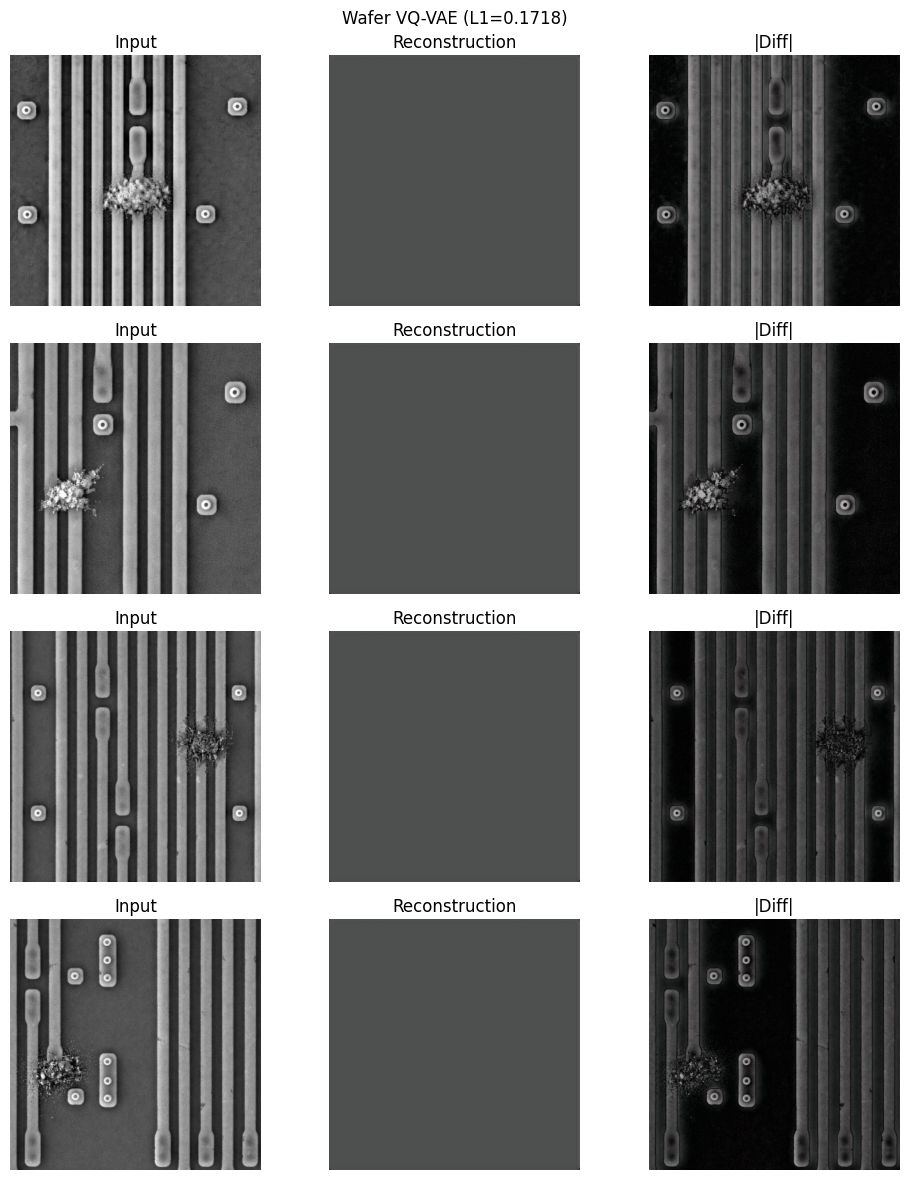

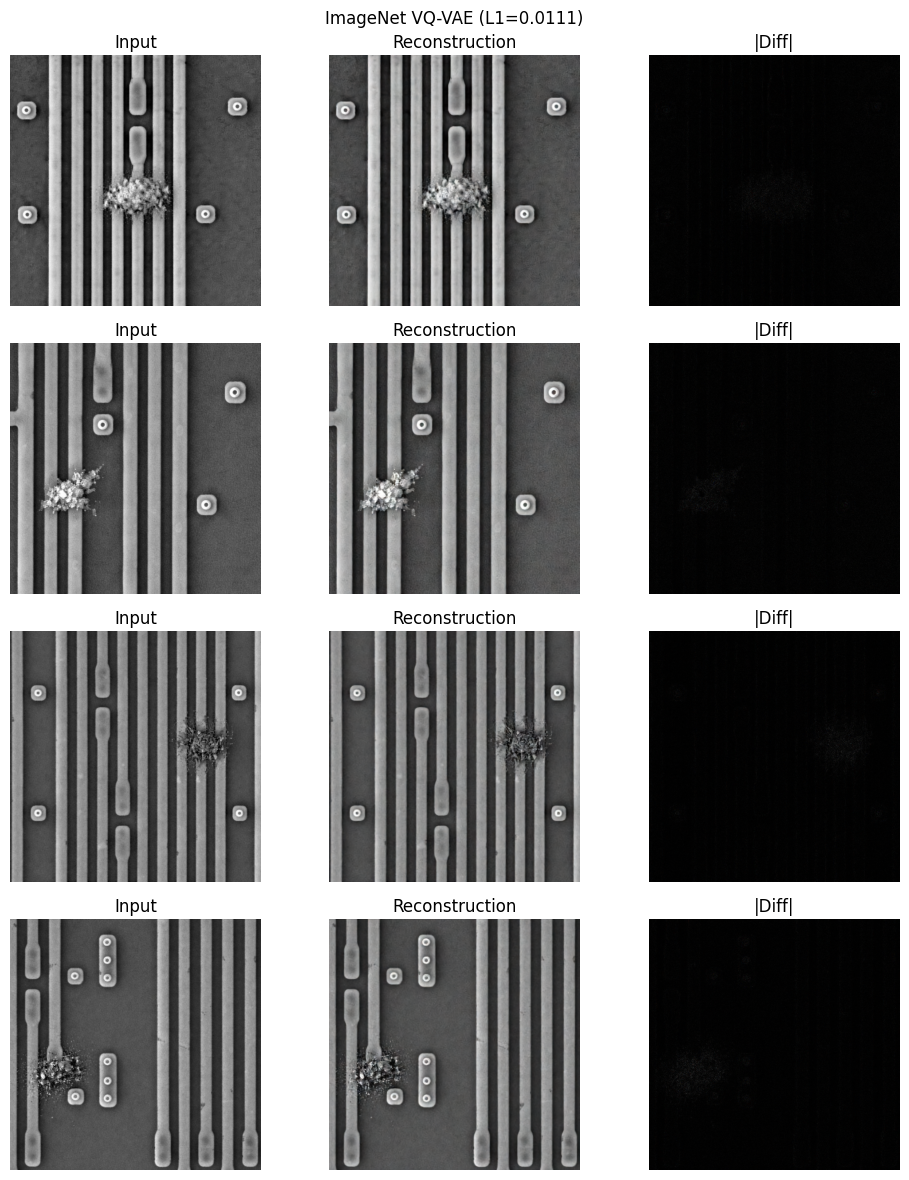

Wafer pretrained:
  Mean L1 : 0.1607574462890625
  Mean MSE: 0.03723317869007588

ImageNet pretrained:
  Mean L1 : 0.007621107576414943
  Mean MSE: 0.0001154622201283928


In [16]:
# ---------------- LOAD MODELS ------------------
wafer_vqvae = load_wafer_vqvae(WAFER_VQVAE_CKPT)
imagenet_vqvae = load_imagenet_vqvae()

# ---------------- RUN MODELS ON 1 BATCH ----------------
x, y = next(iter(test_loader))
x = x.to(DEVICE)

with torch.no_grad():
    out_wafer = wafer_vqvae(x)
    wafer_recon, wafer_key = pick_reconstruction(out_wafer, x)

    out_imgnet = imagenet_vqvae(x)
    imgnet_recon, imgnet_key = pick_reconstruction(out_imgnet, x)

wafer_l1 = F.l1_loss(wafer_recon, x).item()
imgnet_l1 = F.l1_loss(imgnet_recon, x).item()

wafer_l1, imgnet_l1, wafer_key, imgnet_key

# ---------------- VISUALIZE RESULTS ----------------
show_triplet(x, wafer_recon, f"Wafer VQ-VAE (L1={wafer_l1:.4f})")
show_triplet(x, imgnet_recon, f"ImageNet VQ-VAE (L1={imgnet_l1:.4f})")

# ---------------- QUANTITATIVE EVALUATION ----------------
wafer_mean_l1, wafer_mean_mse = evaluate_model(wafer_vqvae, test_loader)
imgnet_mean_l1, imgnet_mean_mse = evaluate_model(imagenet_vqvae, test_loader)

print("Wafer pretrained:")
print("  Mean L1 :", wafer_mean_l1)
print("  Mean MSE:", wafer_mean_mse)

print("\nImageNet pretrained:")
print("  Mean L1 :", imgnet_mean_l1)
print("  Mean MSE:", imgnet_mean_mse)